In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

In [9]:
# g_sub = od+expand(config['lr']['subsample']['gene_summary'], species='human')[0]
# t_sub = od+expand(config['lr']['subsample']['transcript_summary'], species='human')[0]

g_corr_sub = od+expand(config['lr']['subsample']['gene_corr_summary'], species='human', allow_missing=True)[0]
t_corr_sub = od+expand(config['lr']['subsample']['transcript_corr_summary'], species='human', allow_missing=True)[0]

## Dist. of correlations

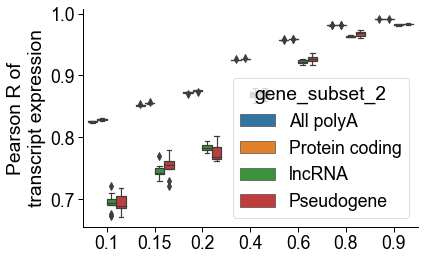

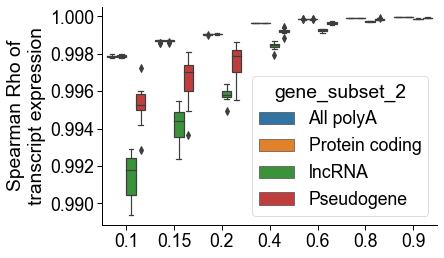

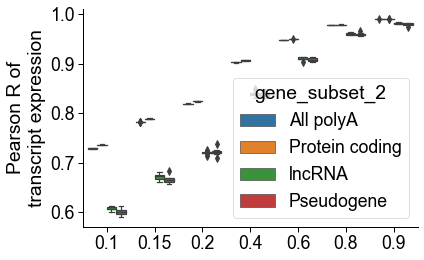

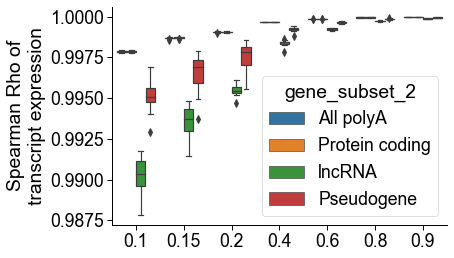

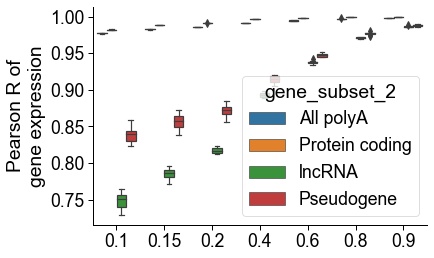

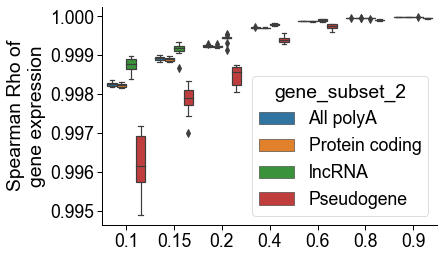

In [19]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

subsample_set = ['inner', 'outer']

# transcript
for sset in subsample_set:
    f = expand(t_corr_sub, subsample_set=sset)[0]
    df = pd.read_csv(f, sep='\t')
    m = {'polya': 'All polyA', 'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
    cats = ['All polyA', 'Protein coding', 'lncRNA', 'Pseudogene']
    df['gene_subset_2'] = df.gene_subset.map(m)
    df['gene_subset_2'] = df['gene_subset_2'].astype('category')
    df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)

    for corr_type in ['pearson_r', 'spearman_rho']:
        ax = sns.boxplot(df, x='depth', hue='gene_subset_2',y=corr_type)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if corr_type=='pearson_r':
            ylabel = 'Pearson R of\ntranscript expression'
        else:
            ylabel = 'Spearman Rho of\ntranscript expression'
        ax.set(ylabel=ylabel, xlabel='')
        plt.show()


# gene
subsample_set = ['inner']
for sset in subsample_set:
    f = expand(g_corr_sub, subsample_set=sset)[0]
    df = pd.read_csv(f, sep='\t')
    m = {'polya': 'All polyA', 'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
    cats = ['All polyA', 'Protein coding', 'lncRNA', 'Pseudogene']
    df['gene_subset_2'] = df.gene_subset.map(m)
    df['gene_subset_2'] = df['gene_subset_2'].astype('category')
    df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)

    for corr_type in ['pearson_r', 'spearman_rho']:
        ax = sns.boxplot(df, x='depth', hue='gene_subset_2',y=corr_type)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if corr_type=='pearson_r':
            ylabel = 'Pearson R of\ngene expression'
        else:
            ylabel = 'Spearman Rho of\ngene expression'
        ax.set(ylabel=ylabel, xlabel='')
        plt.show()
        

## Reads post-TALON for WTC11

In [34]:
meta = pd.read_csv(lib_meta, sep='\t')
meta = meta.loc[meta['sample'] == 'wtc11']
print(meta[['sample', 'dataset', 'reads_post_talon']])
print(f'{meta.reads_post_talon.sum(axis=0)} wtc11 reads post-talon')

    sample    dataset  reads_post_talon
135  wtc11  wtc11_1_1           2332639
136  wtc11  wtc11_1_2           1358180
137  wtc11  wtc11_1_3           2851975
6542794 wtc11 reads post-talon


## Gene / transcript saturation plots @ different depths

In [94]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

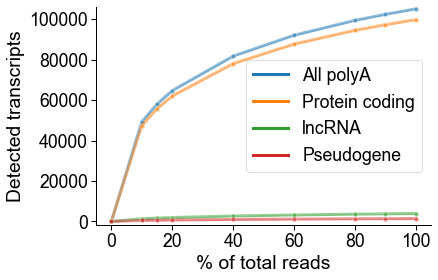

In [101]:
df = pd.read_csv(t_sub, sep='\t')
temp = pd.DataFrame()
subsets = ['polya', 'protein_coding', 'pseudogene', 'lncRNA']
zeroes = [0 for i in range(len(subsets))]
temp['n_transcripts'] = zeroes
temp['depth'] = zeroes
temp['rep'] = zeroes
temp['gene_subset'] = subsets
df = pd.concat([df, temp], axis=0)

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']
m = {'polya': 'All polyA', 'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
cats = ['All polyA', 'Protein coding', 'lncRNA', 'Pseudogene']
df['gene_subset_2'] = df.gene_subset.map(m)
df['gene_subset_2'] = df['gene_subset_2'].astype('category')
df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)
c_dict, order = get_shade_colors(c, cats)

df['perc'] = df.depth*100
sns.set_context('paper', font_scale=2)
ax = sns.lineplot(df, x='perc', y='n_transcripts',
                  hue='gene_subset_2', #palette=c_dict,
                  linewidth=3, marker='o', alpha=0.5)
_ = ax.set(xlabel='% of total reads', ylabel='Detected transcripts',
           ylim=(-1500,106000), xlim=(-5,105))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend_.set_title(None)

# get the legend object
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3)
   
fname = 'figures/subsample_wtc11_transcript_det.pdf'
plt.savefig(fname, dpi=500)

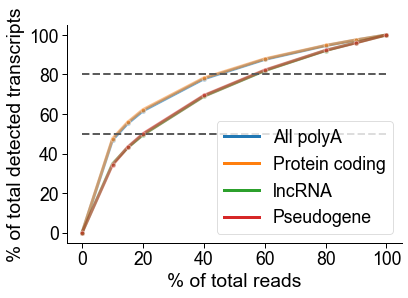

In [102]:
temp = df.copy(deep=True)
temp = temp.loc[(temp.rep==0)&(temp.perc==100)]
temp.drop_duplicates(inplace=True)
temp = temp[['n_transcripts', 'gene_subset']]
temp.rename({'n_transcripts':'n_total_transcripts'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='gene_subset')
df['perc_total_transcripts'] = (df.n_transcripts/df.n_total_transcripts)*100

sns.set_context('paper', font_scale=2)
ax = sns.lineplot(df, x='perc', y='perc_total_transcripts',
                  hue='gene_subset_2', #palette=c_dict,
                  linewidth=3, marker='o', alpha=0.5)
_ = ax.set(xlabel='% of total reads', ylabel='% of total detected transcripts',
           ylim=(-5,105), xlim=(-5,105))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend_.set_title(None)

color = '#5c5c5c'
ax.hlines(50, 0,100,
          colors=color, linestyles='dashed',
          linewidth=2)
ax.hlines(80, 0,100,
          colors=color, linestyles='dashed',
          linewidth=2)

# get the legend object
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3)

fname = 'figures/subsample_wtc11_transcript_det_perc.pdf'
plt.savefig(fname, dpi=500)

In [108]:
# when do we hit 50% and 80% detection?
df = df.sort_values(by='perc_total_transcripts', ascending=True)
for subset in ['polya', 'protein_coding', 'lncRNA', 'pseudogene']:
    for thresh in [50, 80]:
        print()
        print()
        print('entry:')
        print(df.loc[(df.gene_subset==subset)&(df.perc_total_transcripts>=thresh)].head(1))



entry:
    n_transcripts  depth  rep gene_subset gene_subset_2  perc  \
52          57921   0.15    3       polya     All polyA  15.0   

    n_total_transcripts  perc_total_transcripts  
52               105099               55.110895  


entry:
     n_transcripts  depth  rep gene_subset gene_subset_2  perc  \
188          91914    0.6    7       polya     All polyA  60.0   

     n_total_transcripts  perc_total_transcripts  
188               105099               87.454686  


entry:
    n_transcripts  depth  rep     gene_subset   gene_subset_2  perc  \
53          55646   0.15    3  protein_coding  Protein coding  15.0   

    n_total_transcripts  perc_total_transcripts  
53                99758                55.78099  


entry:
     n_transcripts  depth  rep     gene_subset   gene_subset_2  perc  \
189          87529    0.6    7  protein_coding  Protein coding  60.0   

     n_total_transcripts  perc_total_transcripts  
189                99758               87.741334  


entry:

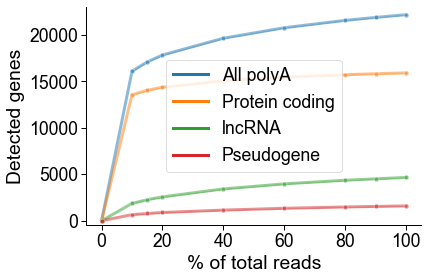

In [98]:
df = pd.read_csv(g_sub, sep='\t')
temp = pd.DataFrame()
subsets = ['polya', 'protein_coding', 'pseudogene', 'lncRNA']
zeroes = [0 for i in range(len(subsets))]
temp['n_genes'] = zeroes
temp['depth'] = zeroes
temp['rep'] = zeroes
temp['gene_subset'] = subsets
df = pd.concat([df, temp], axis=0)

ic_colors, order = get_ic_nov_colors()
c = ic_colors['Known']
m = {'polya': 'All polyA', 'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
cats = ['All polyA', 'Protein coding', 'lncRNA', 'Pseudogene']
df['gene_subset_2'] = df.gene_subset.map(m)
df['gene_subset_2'] = df['gene_subset_2'].astype('category')
df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)
c_dict, order = get_shade_colors(c, cats)

df['perc'] = df.depth*100
ax = sns.lineplot(df, x='perc', y='n_genes',
                  hue='gene_subset_2', #palette=c_dict,
                  linewidth=3, marker='o', alpha=0.5)
_ = ax.set(xlabel='% of total reads', ylabel='Detected genes',
           ylim=(-400,23000), xlim=(-5,105))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend_.set_title(None)

# get the legend object
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3)
    
fname = 'figures/subsample_wtc11_gene_det.pdf'
plt.savefig(fname, dpi=500)

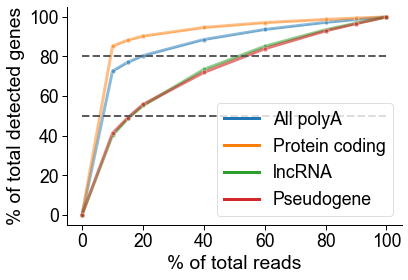

In [99]:
temp = df.copy(deep=True)
temp = temp.loc[(temp.rep==0)&(temp.perc==100)]
temp.drop_duplicates(inplace=True)
temp = temp[['n_genes', 'gene_subset']]
temp.rename({'n_genes':'n_total_genes'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='gene_subset')
df['perc_total_genes'] = (df.n_genes/df.n_total_genes)*100

sns.set_context('paper', font_scale=2)
ax = sns.lineplot(df, x='perc', y='perc_total_genes',
                  hue='gene_subset_2', #palette=c_dict,
                  linewidth=3, marker='o', alpha=0.5)
_ = ax.set(xlabel='% of total reads', ylabel='% of total detected genes',
           ylim=(-5,105), xlim=(-5,105))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend_.set_title(None)

color = '#5c5c5c'
ax.hlines(50, 0,100,
          colors=color, linestyles='dashed',
          linewidth=2)
ax.hlines(80, 0,100,
          colors=color, linestyles='dashed',
          linewidth=2)

# get the legend object
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3)
    
fname = 'figures/subsample_wtc11_gene_det_perc.pdf'
plt.savefig(fname, dpi=500)

In [100]:
# when do we hit 50% and 80% detection?
df = df.sort_values(by='perc_total_transcripts', ascending=True)
for subset in ['polya', 'protein_coding', 'lncRNA', 'pseudogene']:
    for thresh in [50, 80]:
        print(df.loc[(df.gene_subset==subset)&(df.perc_total_transcripts>=thresh)].head(1))

KeyError: 'perc_total_transcripts'

In [63]:
# # individually
# df = pd.read_csv(t_sub, sep='\t')

# sns.set_context('paper', font_scale=2)
# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['pdf.fonttype'] = 42

# ic_colors, order = get_ic_nov_colors()
# c = ic_colors['Known']
# m = {'polya': 'All polyA', 'protein_coding': 'Protein coding',
#      'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene'}
# cats = ['All polyA', 'Protein coding', 'lncRNA', 'Pseudogene']
# df['gene_subset_2'] = df.gene_subset.map(m)
# df['gene_subset_2'] = df['gene_subset_2'].astype('category')
# df['gene_subset_2'] = df['gene_subset_2'].cat.reorder_categories(cats, ordered=True)
# c_dict, order = get_shade_colors(c, cats)

# df['perc'] = df.depth*100

# # log the transcript numbers
# df['log_n_transcripts'] = np.log2(df.n_transcripts)

# for c in df.gene_subset_2.unique().tolist():
#     temp = df.loc[df.gene_subset_2==c]
#     # add 0-read samples
#     temp2 = pd.DataFrame(data=[[0, 0, c]], columns=['n_transcripts', 'perc', 'gene_subset_2'])
#     temp = pd.concat([temp, temp2], axis=0)
#     ax = sns.lineplot(temp, x='perc', y='n_transcripts',
#                       hue='gene_subset_2', palette=c_dict,
#                       linewidth=1, marker='o', err_style='bars')
#     # ax = sns.lineplot(temp, x='perc', y='log_n_transcripts',
#     #               hue='gene_subset_2', palette=c_dict,
#     #               linewidth=1, marker='o', err_style='bars')
#     _ = ax.set(xlabel='% of total reads', ylabel='Detected transcripts',
#                ylim=(-1000,106000), xlim=(-5,105))
#     # _ = ax.set(xlabel='% of total reads', ylabel='Detected transcripts',
#     #             xlim=(-5,105), yscale='log')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    
#     ax.legend_.set_title(None)

#     # get the legend object
#     leg = ax.legend()

#     # change the line width for the legend
#     for line in leg.get_lines():
#         line.set_linewidth(3)
        
#     plt.show()

In [64]:
# df.head()